In [1]:
from sentiment.models import *
from embedding import Embedding
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim
from konlpy.tag import Kkma
from konlpy.utils import pprint
from IPython.display import clear_output

from sentiment.utils import HeadDataLoader

In [2]:
EPOCHS = 10
BATCH_SIZE = 128
ETA = 1e-3
# torch.autograd.set_detect_anomaly(True)

In [3]:
# dloader = DataLoader(10)
train_loader = HeadDataLoader(BATCH_SIZE, mode="train")
valid_loader = HeadDataLoader(BATCH_SIZE, mode="valid")
test_loader = HeadDataLoader(BATCH_SIZE, mode="test")

In [4]:
sentiment_clf = SentimentPredictor().cuda()

In [5]:
optimizer = optim.Adam(sentiment_clf.parameters(), lr=ETA)

In [4]:
bce_criterion = nn.BCELoss()

In [15]:
def compute_accuracy(preds, y):
    preds[preds >= 0.5] = 1
    preds[preds < 0.5] = 0
    
    return torch.mean((y == preds).type(torch.FloatTensor))

In [8]:
def train_step(x, y):
    N = len(x)
    preds = []
    
    for head in x:
        embedded = Embedding.get_sentiment_vector(head).cuda().detach()

        pred = sentiment_clf(embedded.view(1, -1))
        preds.append(pred)
        
    preds = torch.stack(preds, dim=0).view(-1)
            
    loss = bce_criterion(preds, y)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    acc = compute_accuracy(preds, y)
    
    return loss.item(), acc

In [5]:
def test_step(x, y):
    N = len(x)
    preds = []
    
    for head in x:
        embedded = Embedding.get_sentiment_vector(head).cuda().detach()

        pred = sentiment_clf(embedded.view(1, -1))
        preds.append(pred)
        
    preds = torch.stack(preds, dim=0).view(-1)
            
    loss = bce_criterion(preds, y)
    acc = compute_accuracy(preds, y)
    
    return loss.item(), acc

In [13]:
def train_mode():
    #sentence_enc.train()
    #context_enc.train()
    #mine_est.train()
    sentiment_clf.train()

def eval_mode():
    #sentence_enc.eval()
    #context_enc.eval()
    #mine_est.eval()
    sentiment_clf.eval()

In [11]:
def train():
    
    train_losses = []
    train_accs = []
    valid_accs = []
    
    for e in range(EPOCHS):
        
        train_loss = 0.0
        train_acc = 0.0
        valid_loss = 0.0
        valid_acc = 0.0
        
        train_mode()
        
        for x, y in train_loader.next_batch():
            y = torch.FloatTensor(y).cuda()
            loss, acc = train_step(x, y)
            train_loss += loss
            train_acc += acc
        
#             clear_output(wait=True)
#             print(f"train loss: {loss:.6f}, train acc: {acc:.4f}")
            
        train_loss /= len(train_loader)
        train_acc /= len(train_loader)
        
        train_losses.append(train_loss)
        train_accs.append(train_acc)
            
        eval_mode()
        
        with torch.no_grad():
            for x, y in valid_loader.next_batch():
                y = torch.FloatTensor(y).cuda()
                loss, acc = test_step(x, y)
                valid_loss += loss
                valid_acc += acc
        
#                 clear_output(wait=True)
#                 print(f"valid loss: {loss:.6f}, valid acc: {acc:.4f}")
                
        valid_loss /= len(valid_loader)
        valid_acc /= len(valid_loader)
        
        valid_accs.append(valid_acc)
        
        torch.save(sentiment_clf, "sentiment/ckpts/sentiment_clf3.pt")
        
        clear_output(wait=True)

        print(f"Epochs {e+1}/{EPOCHS}")
        print(f"Train loss: {train_loss:.6f}, train acc: {train_acc:.4f}, valid acc: {valid_acc:.4f}")
        
        fig, axes = plt.subplots(1, 3, figsize=(12, 4))
        
        axes[0].plot(train_losses)
        axes[0].set_title("train loss")
        axes[0].set_xlabel("epochs")
        axes[0].set_ylabel("loss")
        
        axes[1].plot(train_accs)
        axes[1].set_title("train acc")
        axes[1].set_xlabel("epochs")
        axes[1].set_ylabel("acc")
        
        axes[2].plot(valid_accs)
        axes[2].set_title("valid acc")
        axes[2].set_xlabel("epochs")
        axes[2].set_ylabel("acc")
        
        plt.tight_layout()
        plt.show()

In [22]:
def test():
            
    eval_mode()
    test_loss = 0
    test_acc = 0

    with torch.no_grad():
        
        y_list = []
        pred_list = []
        
        for x, y in test_loader.next_batch():
            y = torch.FloatTensor(y).cuda()
            N = len(x)
            preds = []

            for head in x:
                embedded = Embedding.get_sentiment_vector(head).cuda().detach()

                pred = sentiment_clf(embedded.view(1, -1))
                preds.append(pred)

            preds = torch.stack(preds, dim=0).view(-1)
            loss = bce_criterion(preds, y)
            acc = compute_accuracy(preds, y)
            
            test_loss += loss
            test_acc += acc
            
            y_list.extend(y.detach().cpu().numpy())
            pred_list.extend(list(preds.detach().cpu().numpy()))
    
    return y_list, pred_list

def test_plot():
    with torch.no_grad():
        for x, y in test_loader.next_batch():
            y = torch.FloatTensor(y).cuda()

            for head in x:
                embedded = Embedding.get_sentiment_vector(head).cuda().detach()

                pred = sentiment_clf(embedded.view(1, -1))
                print(pred, head)

Epochs 10/10
Train loss: 0.509932, train acc: 0.7585, valid acc: 0.7181


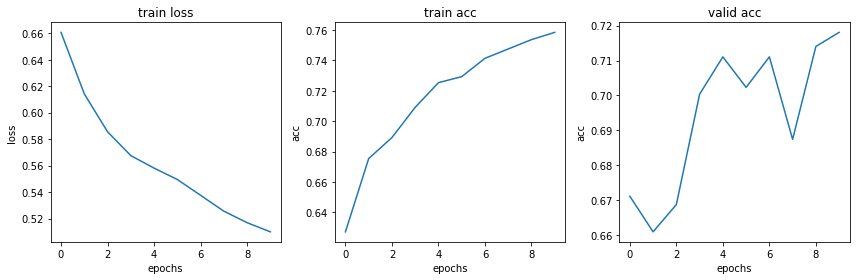

In [13]:
train()

In [14]:
test_plot()

using cached model
tensor([[0.4375]], device='cuda:0') 19분기 연속 적자행진 LG 스마트폰 내년 '혁신제품'은 무엇?
using cached model
tensor([[0.5789]], device='cuda:0') 이노테라피, 파인메딕스와 손잡고 日넘는 내시경 시술 솔루션 공동개발
using cached model
tensor([[0.7515]], device='cuda:0') 한라그룹 정몽원 회장, 직접 최고인사책임자 맡았다
using cached model
tensor([[0.4255]], device='cuda:0') '흥구석유' 10% 이상 상승, 주가 상승세, 단기 이평선 역배열 구간
using cached model
tensor([[0.3538]], device='cuda:0') 권영수 LG 부회장 "SK와 좋은 사이…올해 화두는 공정"
using cached model
tensor([[0.7065]], device='cuda:0') 휴비츠, 검안기기 판매 호조로 올해 실적 성장 기대 -유안타
using cached model
tensor([[0.4986]], device='cuda:0') '한솔제지' 5% 이상 상승, 주가 60일 이평선 상회, 단기·중기 이평선 역배열
using cached model
tensor([[0.3700]], device='cuda:0') [우한폐렴] 현대차그룹, 우한폐렴 피해지역에 25억
using cached model
tensor([[0.7365]], device='cuda:0') 이에스에이, 60억 3자배정 유상증자
using cached model
tensor([[0.6726]], device='cuda:0') LG생활건강, 샤프란 아우라 신규 모델로 펭수 발탁
using cached model
tensor([[0.5765]], device='cuda:0') PN풍년, 블리스 라레트로 뷰 IH 냄비 체험단 모집
using cached model
tensor([[0.1

In [24]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

sentiment_clf = torch.load("sentiment/ckpts/sentiment_clf3.pt")
ys, preds = test()

using cached model
using cached model
using cached model
using cached model
using cached model
using cached model
using cached model
using cached model
using cached model
using cached model
using cached model
using cached model
using cached model
using cached model
using cached model
using cached model
using cached model
using cached model
using cached model
using cached model
using cached model
using cached model
using cached model
using cached model
using cached model
using cached model
using cached model
using cached model
using cached model
using cached model
using cached model
using cached model
using cached model
using cached model
using cached model
using cached model
using cached model
using cached model
using cached model
using cached model
using cached model
using cached model
using cached model
using cached model
using cached model
using cached model
using cached model
using cached model
using cached model
using cached model
using cached model
using cached model
using cached

In [33]:
tp = 0
tn = 0
fp = 0
fn = 0

for i in range(len(ys)):
    if ys[i] == preds[i] == 1:
        tp += 1
    elif ys[i] == 1 and preds[i] == 0:
        fn += 1
    elif ys[i] == 0 and preds[i] == 1:
        fp += 1
    else:
        tn += 1

In [34]:
confusion_mat = np.array([[tp, fp], [fn, tn]])

In [10]:
data = {'y_Actual':    ["a", "b", "a", "b", "a", "b", "a", "b"],
        'y_Predicted': ["a", "a", "a", "a", "a", "a", "a", "b"]
        }

df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])

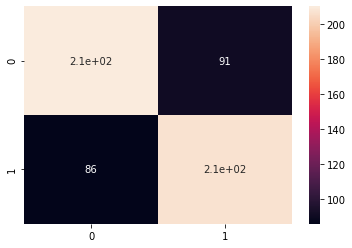

In [36]:
sn.heatmap(confusion_mat, annot=True)
plt.show()